# QCut to Three Parts

In [1]:
import QCut as ck
from QCut import cut_wire
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Estimator

c:\Users\nivalajo\AppData\Local\miniconda3\envs\testenv\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


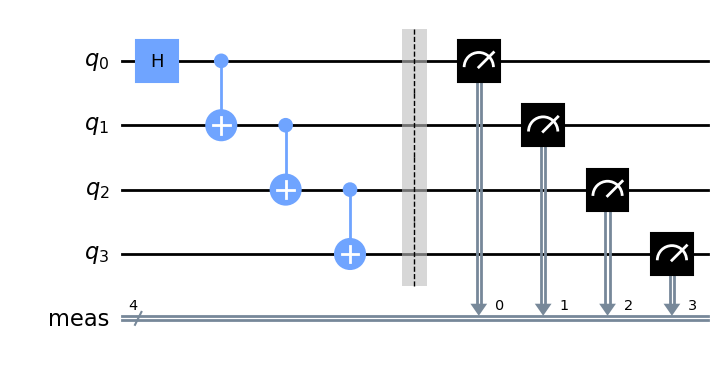

In [2]:
#define initial circuit

circuit = QuantumCircuit(4)
circuit.h(0)
circuit.cx(0,1)
circuit.cx(1,2)
circuit.cx(2,3)
circuit.measure_all()

circuit.draw("mpl")

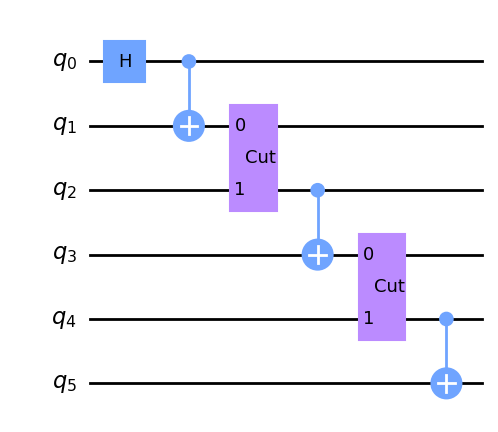

In [3]:
#insert cuts

cut_circuit = QuantumCircuit(6)
cut_circuit.h(0)
cut_circuit.cx(0,1)
cut_circuit.append(cut_wire, [1,2])
cut_circuit.cx(2,3)
cut_circuit.append(cut_wire, [3,4])
cut_circuit.cx(4,5)

cut_circuit.draw("mpl")

In [4]:
#find cut locations and separate into subcircuits

cut_locations, subcircuits = ck.get_locations_and_subcircuits(cut_circuit)

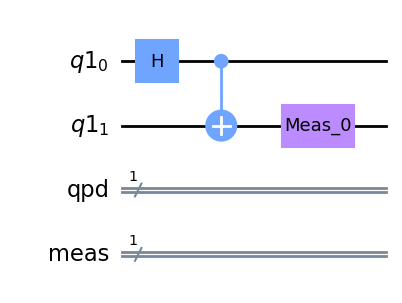

In [5]:
subcircuits[0].draw("mpl")

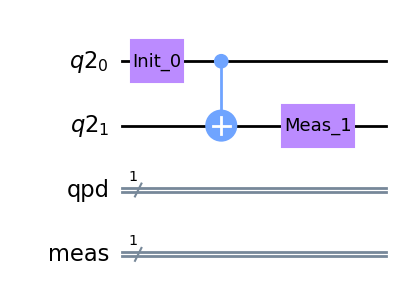

In [6]:
subcircuits[1].draw("mpl")

In [7]:
#insert qpd operations to get the 8^n experiment circuits, where n is the number of cuts made
#also returns coefficients used for reconstructing the expectation values
#and locations of identity basis measurements that get added with post processing

experiment_circuits, coefficients, id_meas = ck.get_experiment_circuits(subcircuits, cut_locations)


In [8]:
#define backend
backend = AerSimulator()

In [9]:
#run experiment circuits
#run_experiments() also post processes the results

results = ck.run_experiments(experiment_circuits, cut_locations, id_meas, backend=backend, mitigate=False)

In [10]:
#define observables to calculate expectation values for
observables = [0,1,2,3, [0,2], [0,1,3]]

#get the exact expectation values with ideal simulator
expectation_values = ck.estimate_expectation_values(results, coefficients, cut_locations, observables)

In [11]:
#transform observables into a PauliList for the Qiskit Estimator
paulilist_observables = ck.get_pauli_list(observables, circuit.num_qubits)

#get the exact expectation values with ideal simulator
estimator = Estimator(run_options={"shots": None}, approximation=True)
exact_expvals = (
    estimator.run([circuit] * len(paulilist_observables),  # noqa: PD011
                  list(paulilist_observables)).result().values
)

In [12]:
import numpy as np

#set numpy print options
np.set_printoptions(formatter={"float": lambda x: f"{x:0.6f}"})
expectation_values = np.array(expectation_values).astype(float)

#compare QCut to Estimator
print(f"QCut circuit knitting expectation values:{np.array(expectation_values)}")
print(f"Exact expectation values with ideal simulator :{np.array(exact_expvals)}")

QCut circuit knitting expectation values:[0.002290 0.002290 0.012985 -0.018276 0.986128 -0.018276]
Exact expectation values with ideal simulator :[0.000000 0.000000 0.000000 0.000000 1.000000 0.000000]
